In [1]:
import kagglehub
birdy654_cifake_real_and_ai_generated_synthetic_images_path = kagglehub.dataset_download('birdy654/cifake-real-and-ai-generated-synthetic-images')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image libraries
import cv2

In [3]:
# directories
train_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

w,h = 32,32
batch_size = 32

train_data_gen = ImageDataGenerator(rescale = 1.0/255)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [4]:
train_Dataset.class_indices

{'FAKE': 0, 'REAL': 1}

In [5]:
train_Dataset.image_shape

(32, 32, 3)

# CNN Model

In [6]:
# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Save best model
weight_path = '/kaggle/working/best_model.weights.h5'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)

# Run Model

idk, why kaggle isn't using GPU here, run 5-10 epochs atleast.

In [9]:
history = model.fit(train_Dataset,
                    epochs=2,
                    validation_data=test_Dataset,
                    callbacks=[model_checkpoint]
                   )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8068 - loss: 0.4105

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 586s 186ms/step - accuracy: 0.8068 - loss: 0.4105 - val_accuracy: 0.8961 - val_loss: 0.2461
Epoch 2/2
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 133s 42ms/step - accuracy: 0.9047 - loss: 0.2352 - val_accuracy: 0.9105 - val_loss: 0.2212


In [10]:
# load best weights to model
model.load_weights(weight_path)

# make prediction
predictions = model.predict(test_Dataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step


In [11]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     10000
           1       0.94      0.87      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



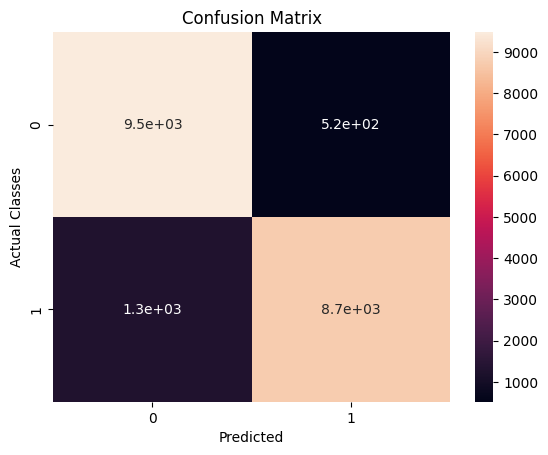

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()